# Intestinal organoid differentiation - Fate mapping

Fate analysis using velocities derived from metabolic labeling.

## Library imports

In [1]:
import sys

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
from anndata import AnnData

from cr2 import get_state_purity, get_var_ranks, plot_state_purity, running_in_notebook

sys.path.extend(["../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3
cr.settings.verbosity = 2

In [3]:
scv.settings.set_figure_params("scvelo")

In [4]:
SAVE_FIGURES = False

if SAVE_FIGURES:
    (FIG_DIR / "labeling_kernel").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

In [5]:
(DATA_DIR / "sceu_organoid" / "results").mkdir(parents=True, exist_ok=True)

## Data loading

In [6]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'labeled', 'total', 'unlabeled'
    obsp: 'connectivities', 'distances'

In [7]:
pd.DataFrame(adata.obs[["labeling_time", "experiment"]].groupby("experiment").apply(lambda x: x.value_counts())).rename(
    {0: "value_counts"}, axis=1
).droplevel(level=2).sort_index()

count
experiment labeling_time       
Chase      0.00             647
           0.75             805
           6.00             632
Pulse      2.00            1368

## Data preprocessing

In [8]:
adata.layers["labeled_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["labeled"]).A
adata.layers["unlabeled_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["unlabeled"]).A
adata.layers["total_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["total"]).A

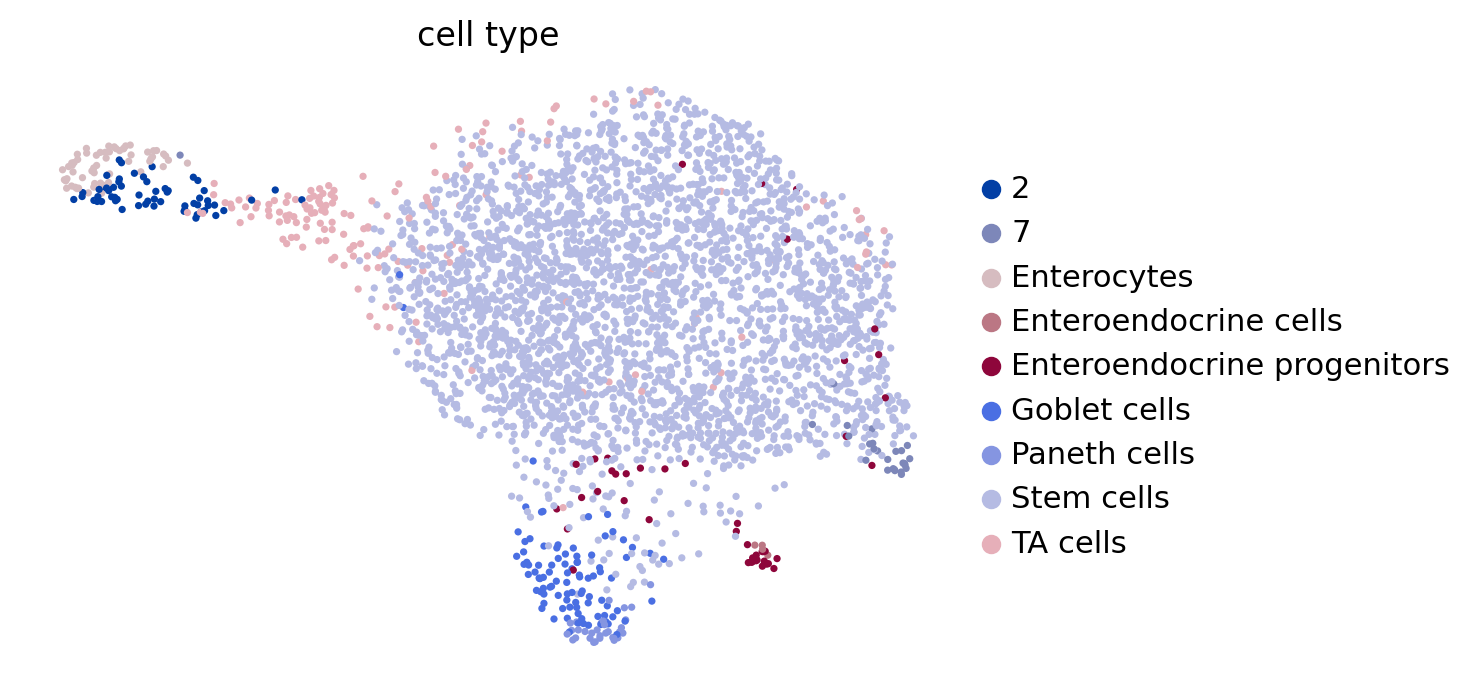

In [9]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color="cell_type", legend_loc="right")

## Parameter inference

In [10]:
alpha = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "alpha.csv", index_col=0)
alpha.index = alpha.index.astype(str)
adata.layers["transcription_rate"] = alpha.loc[adata.obs_names, adata.var_names]

gamma = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "gamma.csv", index_col=0)
gamma.index = gamma.index.astype(str)
adata.layers["degradation_rate"] = gamma.loc[adata.obs_names, adata.var_names]

r0 = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "r0.csv", index_col=0)
r0.index = r0.index.astype(str)
adata.layers["r0"] = r0.loc[adata.obs_names, adata.var_names]

success = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "success.csv", index_col=0)

## Velocity

In [11]:
adata.layers["velocity_labeled"] = (alpha - gamma * adata.layers["labeled_smoothed"]).values

## CellRank

In [12]:
vk = cr.kernels.VelocityKernel(adata, xkey="labeled_smoothed", vkey="velocity_labeled").compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix using `'deterministic'` model


  0%|          | 0/3452 [00:00<?, ?cell/s]

Using `softmax_scale=2.4573`


  0%|          | 0/3452 [00:00<?, ?cell/s]

    Finish (0:00:05)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


### Estimator analysis

In [13]:
estimator = cr.estimators.GPCCA(combined_kernel)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


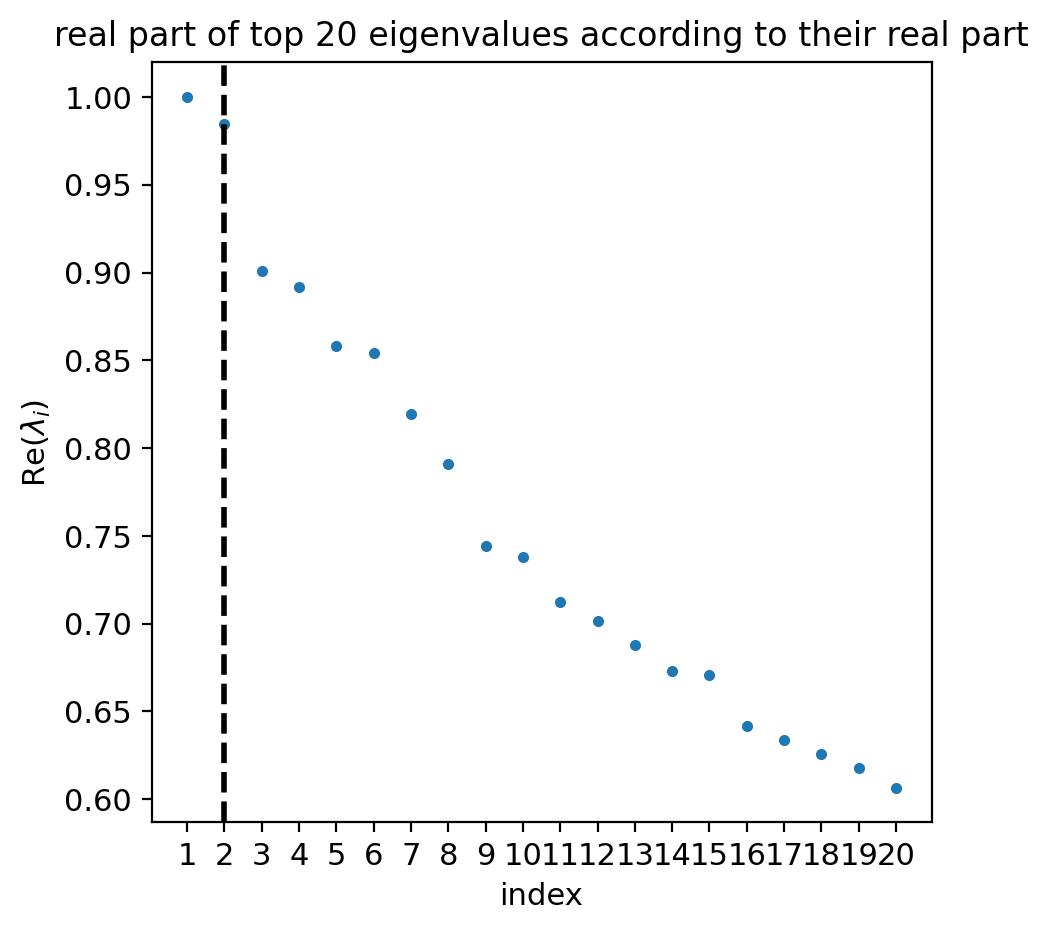

In [14]:
estimator.compute_schur(n_components=20)
if running_in_notebook():
    estimator.plot_spectrum(real_only=True)

#### Macrostates

In [15]:
terminal_states = ["Enteroendocrine progenitors", "Enterocytes", "Goblet cells", "Paneth cells"]
cluster_key = "cell_type"

if (DATA_DIR / "sceu_organoid" / "results" / "tsi-labeling_approach.csv").is_file():
    tsi_df = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "tsi-labeling_approach.csv")
    estimator._tsi = AnnData(tsi_df, uns={"terminal_states": terminal_states, "cluster_key": cluster_key})
    tsi_score = estimator.tsi(n_macrostates=17, terminal_states=terminal_states, cluster_key=cluster_key)
else:
    tsi_score = estimator.tsi(n_macrostates=17, terminal_states=terminal_states, cluster_key=cluster_key)
    estimator._tsi.to_df().to_csv(DATA_DIR / "sceu_organoid" / "results" / "tsi-labeling_approach.csv", index=False)

print(f"TSI score: {tsi_score:.2f}")

TSI score: 0.81


/vol/storage/miniconda3/envs/cr2-py38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


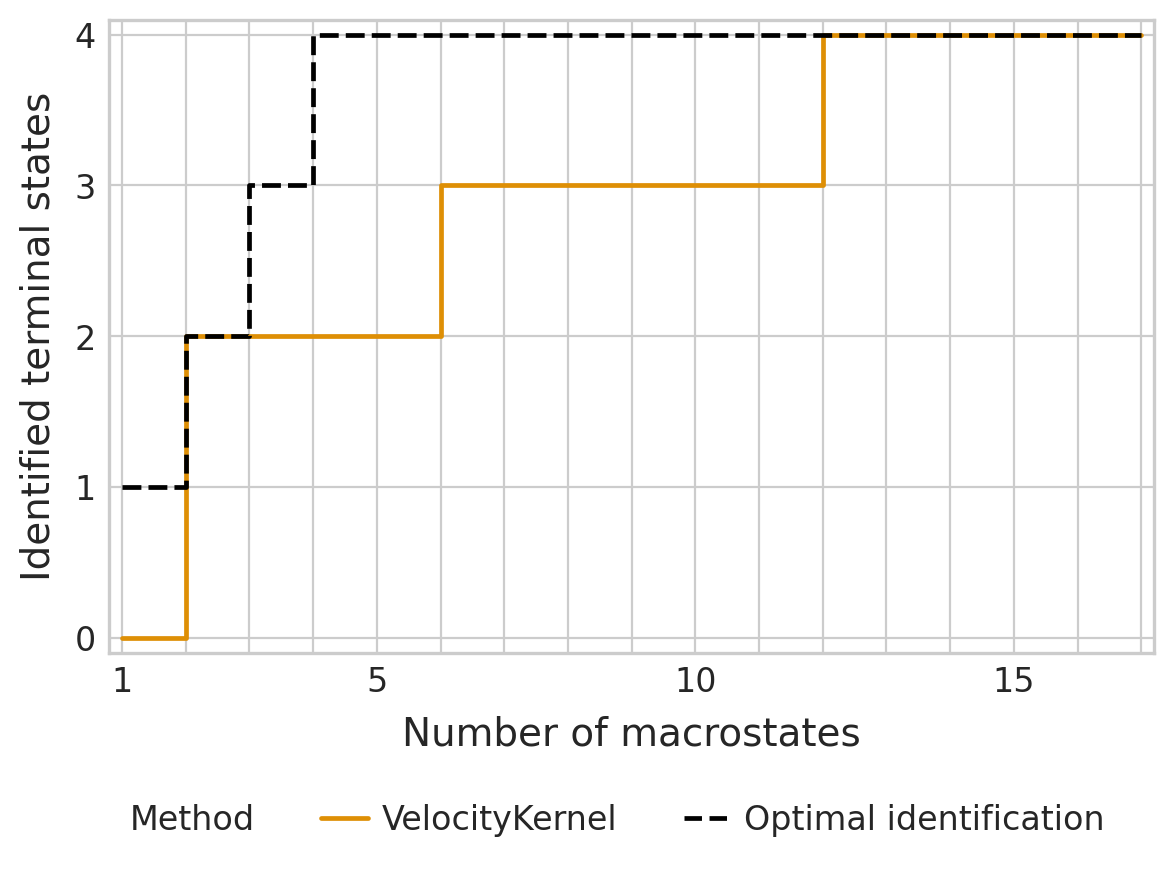

In [16]:
# For nice name in figure legend
estimator.kernel.__class__.__name__ = "VelocityKernel"
palette = {"VelocityKernel": "#DE8F05", "Optimal identification": "#000000"}

if SAVE_FIGURES:
    fpath = FIG_DIR / "labeling_kernel" / f"tsi-labeling_approach.{FIGURE_FORMAT}"
else:
    fpath = None

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    estimator.plot_tsi(palette=palette, save=fpath)
    plt.show()

Computing `12` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:05)


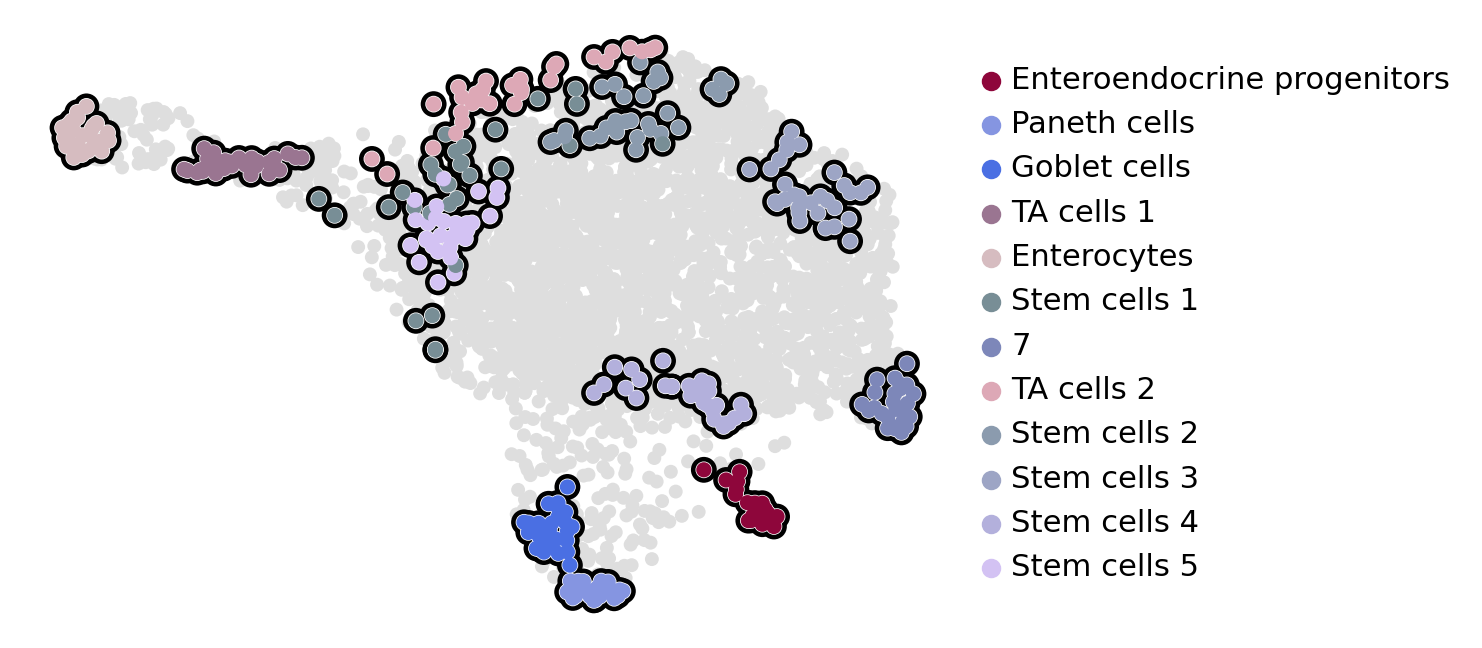

In [17]:
estimator.compute_macrostates(n_states=12, cluster_key="cell_type")

if running_in_notebook():
    estimator.plot_macrostates(which="all", basis="umap", legend_loc="right", title="", size=100)
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / f"umap_colored_by_cr_macrostates.{FIGURE_FORMAT}"
        estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc=False, size=100, save=fpath)

Mean purity: 0.8222222222222223


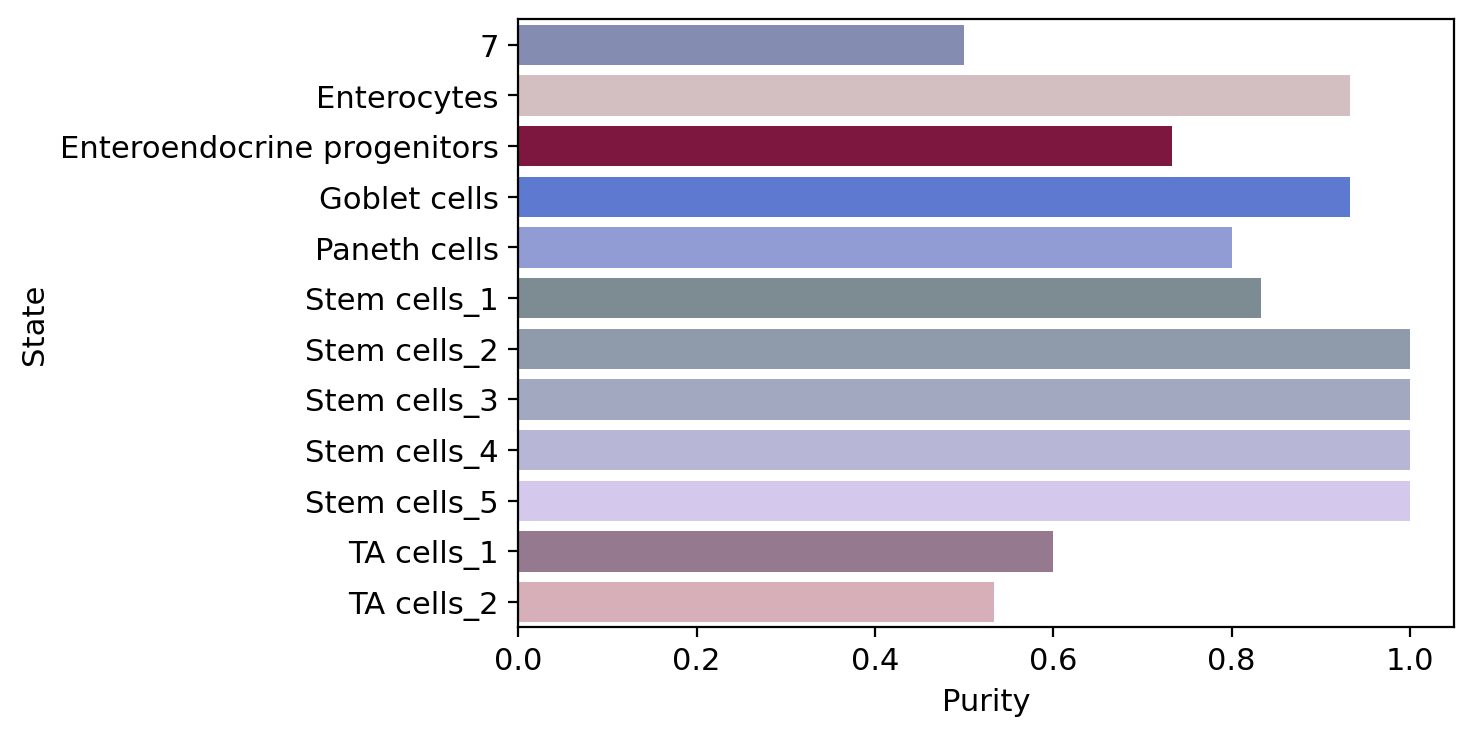

In [18]:
macrostate_purity = get_state_purity(adata, estimator, states="macrostates", obs_col="cell_type")
print(f"Mean purity: {np.mean(list(macrostate_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / f"macrostate_purity_labeling_velo.{FIGURE_FORMAT}"
    else:
        fpath = None

    palette = dict(zip(estimator.macrostates.cat.categories, estimator._macrostates.colors))
    order = estimator.macrostates.cat.categories.sort_values().to_list()
    plot_state_purity(macrostate_purity, palette=palette, order=order, fpath=fpath, format=FIGURE_FORMAT)

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


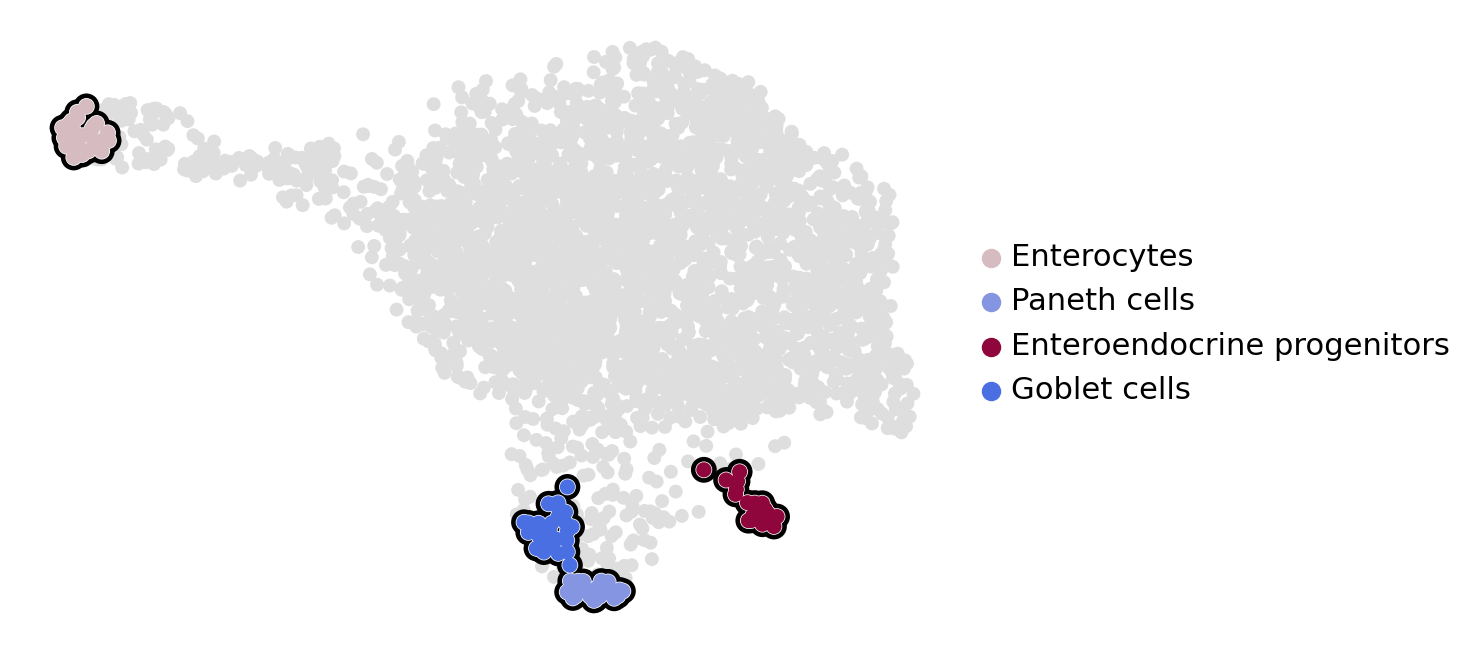

In [19]:
estimator.set_terminal_states(states=["Enterocytes", "Paneth cells", "Enteroendocrine progenitors", "Goblet cells"])

pd.DataFrame(adata.obs["term_states_fwd"]).rename(columns={"term_states_fwd": "terminal_state"}).to_csv(
    DATA_DIR / "sceu_organoid" / "results" / "cr_terminal_states.csv"
)

if running_in_notebook():
    estimator.plot_macrostates(which="terminal", basis="umap", legend_loc="right", title="", size=100)
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / f"umap_colored_by_cr_terminal_states.{FIGURE_FORMAT}"
        estimator.plot_macrostates(which="terminal", basis="umap", title="", legend_loc=False, size=100, save=fpath)

Mean purity: 0.8500000000000001


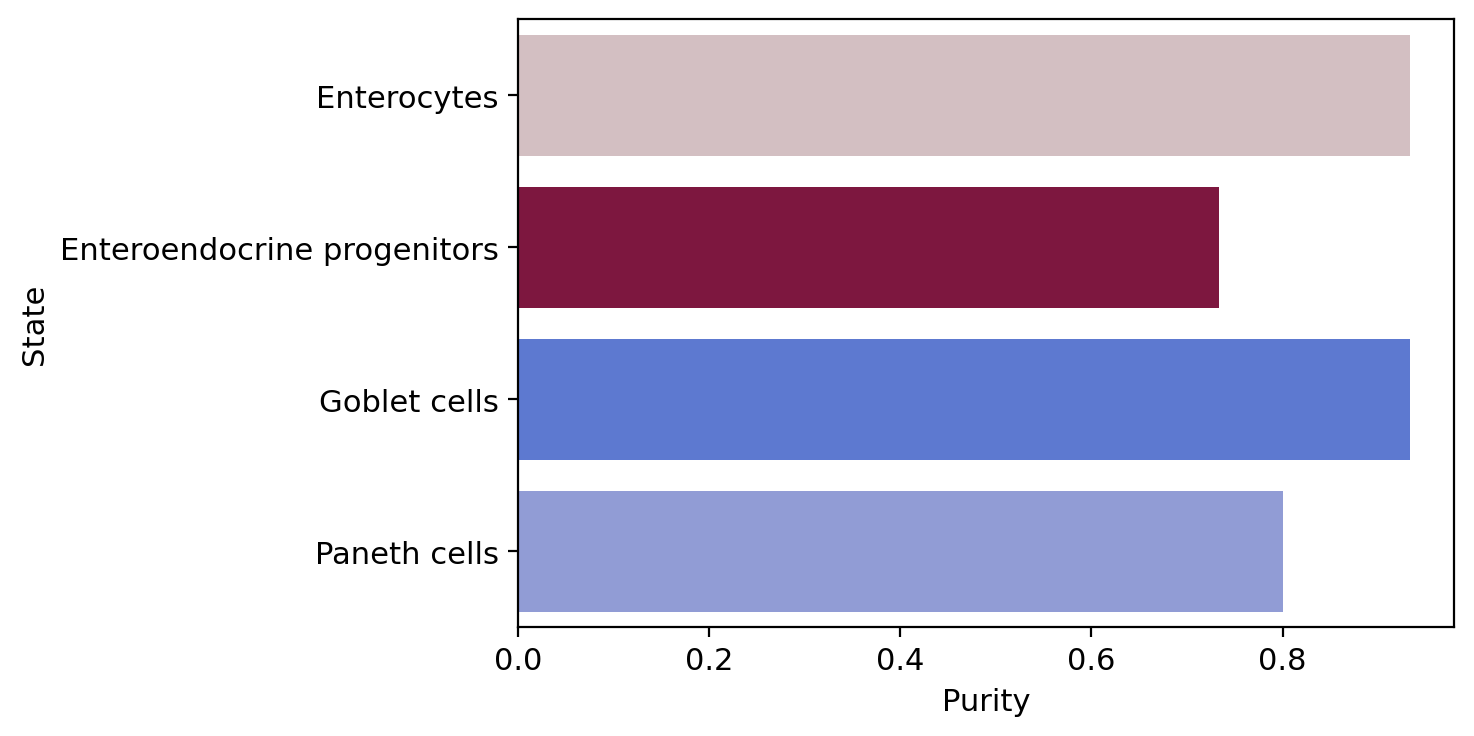

In [20]:
terminal_state_purity = get_state_purity(adata, estimator, states="terminal_states", obs_col="cell_type")
print(f"Mean purity: {np.mean(list(terminal_state_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / f"terminal_state_purity_labeling_velo.{FIGURE_FORMAT}"
    else:
        fpath = None

    palette = dict(zip(estimator.terminal_states.cat.categories, estimator._term_states.colors))
    order = estimator.terminal_states.cat.categories.sort_values().to_list()
    plot_state_purity(terminal_state_purity, palette=palette, order=order, fpath=fpath, format=FIGURE_FORMAT)

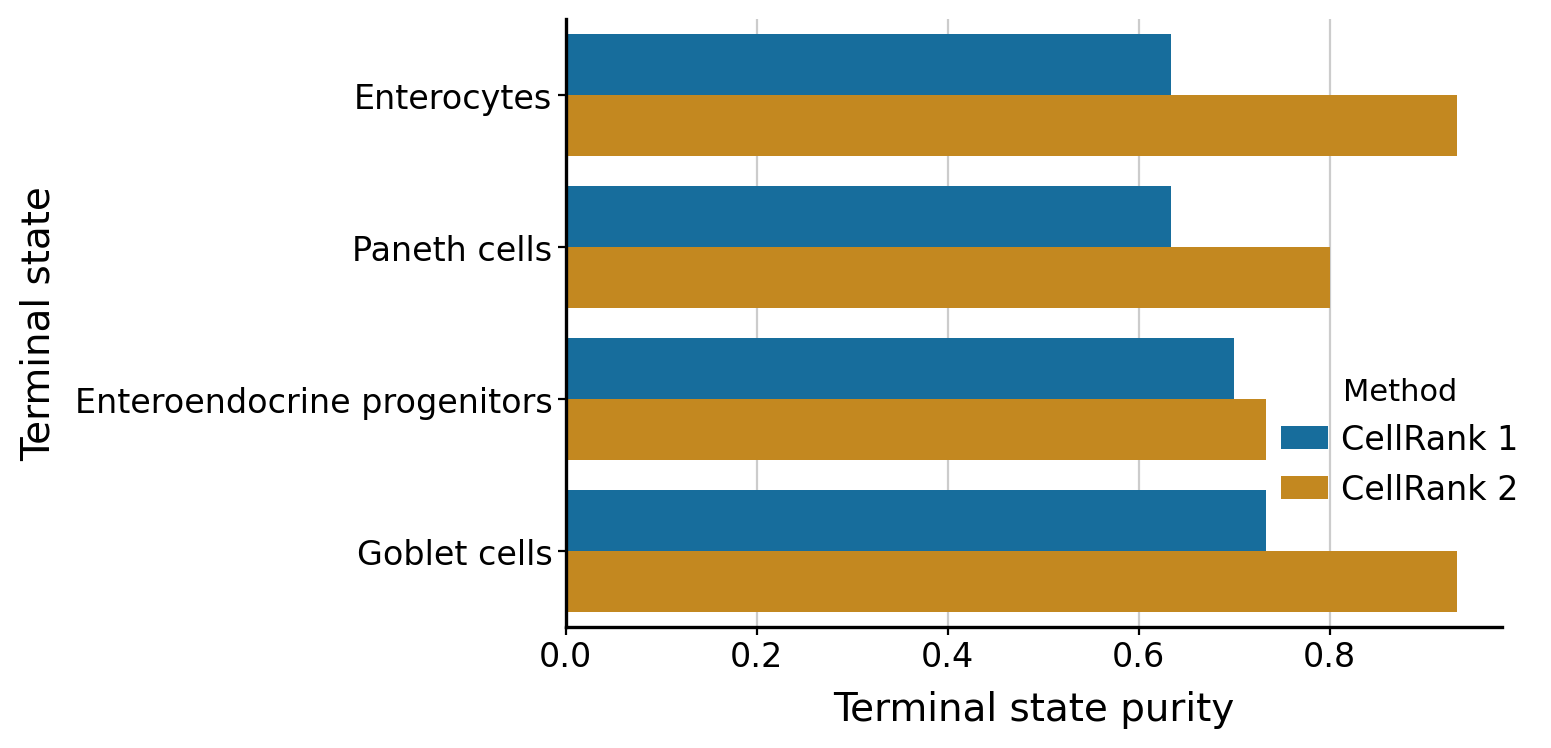

In [21]:
if (DATA_DIR / "sceu_organoid" / "results" / "terminal_state_purity_cr1.csv").is_file():
    df = pd.concat(
        [
            pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "terminal_state_purity_cr1.csv"),
            pd.DataFrame(
                {
                    "state": terminal_state_purity.keys(),
                    "purity": terminal_state_purity.values(),
                    "method": "CellRank 2",
                },
            ),
        ]
    ).rename(columns={"state": "Terminal state", "purity": "Terminal state purity", "method": "Method"})

    with mplscience.style_context():
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.barplot(
            data=df,
            x="Terminal state purity",
            y="Terminal state",
            hue="Method",
            palette=sns.color_palette("colorblind").as_hex()[:2],
            ax=ax,
        )
        sns.move_legend(ax, "lower right", bbox_to_anchor=(1.05, 0.15))
        ax.set_axisbelow(True)
        ax.xaxis.grid(True)

        if SAVE_FIGURES:
            fig.savefig(
                FIG_DIR / "labeling_kernel" / f"terminal_state_purity_cr1_vs_cr2.{FIGURE_FORMAT}",
                format=FIGURE_FORMAT,
                transparent=True,
                bbox_inches="tight",
            )
else:
    print(
        "To compare the terminal state purity based on CellRank 1 and 2 requires "
        "running `notebooks/labeling_kernel/rna_velocity/em_model.ipynb` first."
    )

#### Fate probabilities

In [22]:
estimator.compute_fate_probabilities()

Computing fate probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


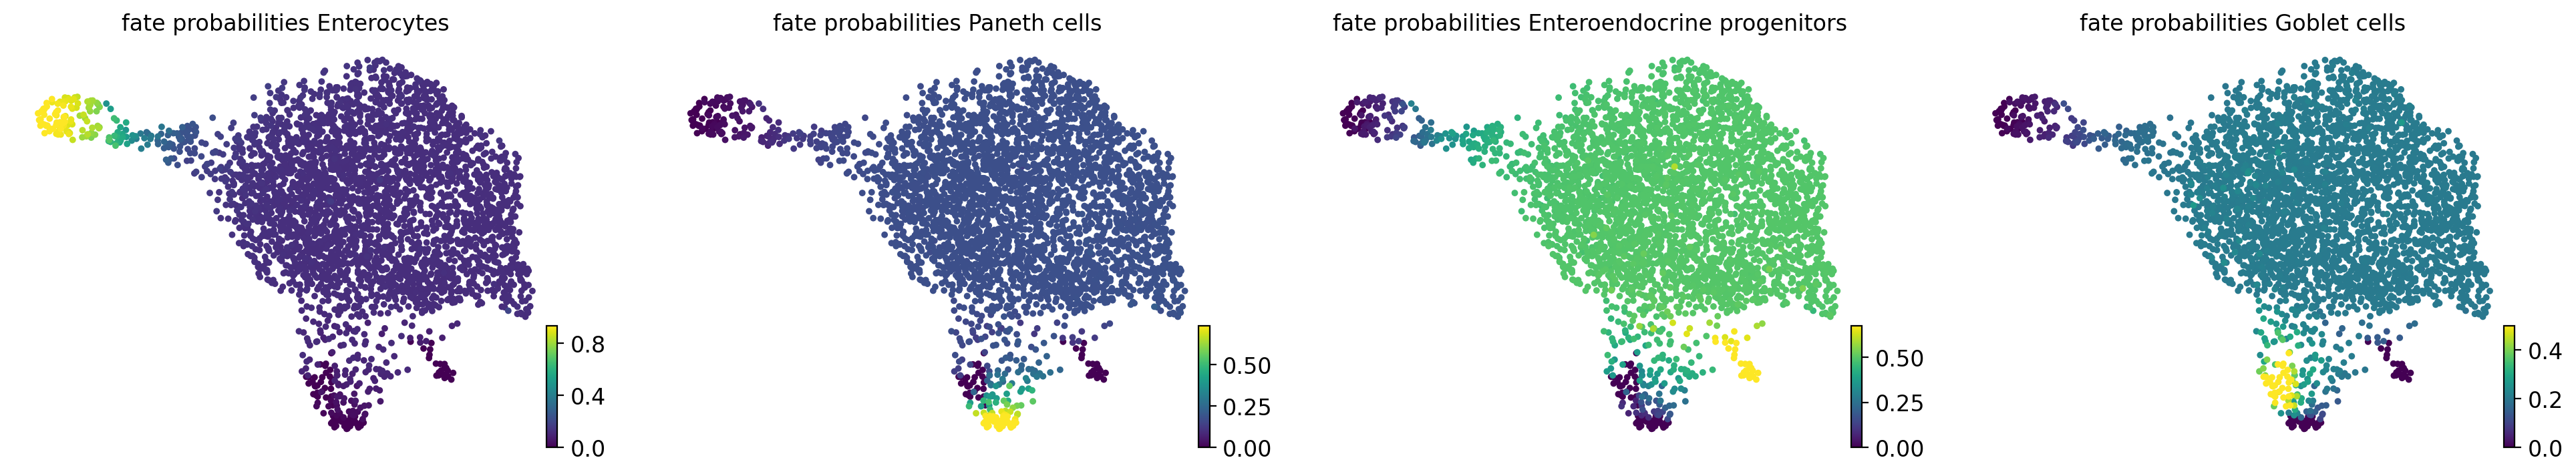

In [23]:
if running_in_notebook():
    estimator.plot_fate_probabilities(same_plot=False, size=50, basis="umap")

### Driver analysis

In [24]:
gene_ranks = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}
gene_ranks_gex = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}

In [25]:
drivers = {}
for terminal_state in terminal_states:
    drivers[terminal_state] = estimator.compute_lineage_drivers(
        layer="transcription_rate",
        cluster_key="cell_type",
        lineages=[terminal_state],
        clusters=["Stem cells", terminal_state],
        return_drivers=True,
    )
    drivers[terminal_state] = drivers[terminal_state].merge(
        pd.DataFrame(drivers[terminal_state].sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename({"index": f"Corr. rank - {terminal_state}", 0: "Gene"}, axis=1)
        .set_index("Gene"),
        left_index=True,
        right_index=True,
    )

drivers = pd.concat(drivers.values(), axis=1)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


In [26]:
drivers_gex = {}
for terminal_state in terminal_states:
    drivers_gex[terminal_state] = estimator.compute_lineage_drivers(
        layer="labeled_smoothed",
        cluster_key="cell_type",
        lineages=[terminal_state],
        clusters=["Stem cells", terminal_state],
        return_drivers=True,
    )
    drivers_gex[terminal_state] = drivers_gex[terminal_state].merge(
        pd.DataFrame(drivers_gex[terminal_state].sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename({"index": f"Corr. rank - {terminal_state}", 0: "Gene"}, axis=1)
        .set_index("Gene"),
        left_index=True,
        right_index=True,
    )

drivers_gex = pd.concat(drivers_gex.values(), axis=1)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


#### Driver analysis - Goblet

In [27]:
goblet_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_markers.csv")["Gene"].str.lower().tolist()
)

goblet_markers = adata.var_names[adata.var_names.str.lower().isin(goblet_markers)]

In [28]:
goblet_regulators = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_regulators.csv")["Gene"].str.lower().tolist()
)

goblet_regulators = adata.var_names[adata.var_names.str.lower().isin(goblet_regulators)]

In [29]:
goblet_and_paneth_regulators = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_and_paneth_regulators.csv")["Gene"]
    .str.lower()
    .tolist()
)

goblet_and_paneth_regulators = adata.var_names[adata.var_names.str.lower().isin(goblet_and_paneth_regulators)]

In [30]:
_df = get_var_ranks(
    var_names=goblet_markers, drivers=drivers, macrostate="Goblet cells", var_type="Marker", model="CR2"
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Marker towards Goblet cells for CR2 in top 100: 23 (out of 85)


In [31]:
_df = get_var_ranks(
    var_names=goblet_markers, drivers=drivers_gex, macrostate="Goblet cells", var_type="Marker", model="CR2 - GEX"
)
gene_ranks_gex["Goblet cells"] = pd.concat([gene_ranks_gex["Goblet cells"], _df])

Marker towards Goblet cells for CR2 - GEX in top 100: 33 (out of 85)


In [32]:
_df = get_var_ranks(
    var_names=goblet_regulators,
    drivers=drivers,
    macrostate="Goblet cells",
    var_type="Goblet regulator",
    model="CR2",
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Goblet regulator towards Goblet cells for CR2 in top 100: 2 (out of 8)


In [33]:
_df = get_var_ranks(
    var_names=goblet_regulators,
    drivers=drivers_gex,
    macrostate="Goblet cells",
    var_type="Goblet regulator",
    model="CR2 - GEX",
)
gene_ranks_gex["Goblet cells"] = pd.concat([gene_ranks_gex["Goblet cells"], _df])

Goblet regulator towards Goblet cells for CR2 - GEX in top 100: 1 (out of 8)


In [34]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers,
    macrostate="Goblet cells",
    var_type="Goblet/Paneth regulator",
    model="CR2",
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Goblet/Paneth regulator towards Goblet cells for CR2 in top 100: 2 (out of 5)


In [35]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers_gex,
    macrostate="Goblet cells",
    var_type="Goblet/Paneth regulator",
    model="CR2 - GEX",
)
gene_ranks_gex["Goblet cells"] = pd.concat([gene_ranks_gex["Goblet cells"], _df])

Goblet/Paneth regulator towards Goblet cells for CR2 - GEX in top 100: 0 (out of 5)


#### Driver analysis - Paneth

In [36]:
paneth_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "paneth_markers.csv")["Gene"].str.lower().tolist()
)

paneth_markers = adata.var_names[adata.var_names.str.lower().isin(paneth_markers)]

In [37]:
_df = get_var_ranks(
    var_names=paneth_markers, drivers=drivers, macrostate="Paneth cells", var_type="Marker", model="CR2"
)
gene_ranks["Paneth cells"] = pd.concat([gene_ranks["Paneth cells"], _df])

Marker towards Paneth cells for CR2 in top 100: 10 (out of 18)


In [38]:
_df = get_var_ranks(
    var_names=paneth_markers, drivers=drivers_gex, macrostate="Paneth cells", var_type="Marker", model="CR2 - GEX"
)
gene_ranks_gex["Paneth cells"] = pd.concat([gene_ranks_gex["Paneth cells"], _df])

Marker towards Paneth cells for CR2 - GEX in top 100: 14 (out of 18)


In [39]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers,
    macrostate="Paneth cells",
    var_type="Goblet/Paneth regulator",
    model="CR2",
)
gene_ranks["Paneth cells"] = pd.concat([gene_ranks["Paneth cells"], _df])

Goblet/Paneth regulator towards Paneth cells for CR2 in top 100: 1 (out of 5)


In [40]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers_gex,
    macrostate="Paneth cells",
    var_type="Goblet/Paneth regulator",
    model="CR2 - GEX",
)
gene_ranks_gex["Paneth cells"] = pd.concat([gene_ranks_gex["Paneth cells"], _df])

Goblet/Paneth regulator towards Paneth cells for CR2 - GEX in top 100: 0 (out of 5)


#### Driver analysis - Enteroendocrine

In [41]:
eec_markers = pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "eec_markers.csv")["Gene"].str.lower().tolist()

eec_markers = adata.var_names[adata.var_names.str.lower().isin(eec_markers)]

In [42]:
eec_progenitor_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "eec_progenitor_markers.csv")["Gene"].str.lower().tolist()
)

eec_progenitor_markers = adata.var_names[adata.var_names.str.lower().isin(eec_progenitor_markers)]

In [43]:
_df = get_var_ranks(
    var_names=eec_markers,
    drivers=drivers,
    macrostate="Enteroendocrine progenitors",
    var_type="Marker",
    model="CR2",
)
gene_ranks["Enteroendocrine progenitors"] = pd.concat([gene_ranks["Enteroendocrine progenitors"], _df])

Marker towards Enteroendocrine progenitors for CR2 in top 100: 29 (out of 95)


In [44]:
_df = get_var_ranks(
    var_names=eec_markers,
    drivers=drivers_gex,
    macrostate="Enteroendocrine progenitors",
    var_type="Marker",
    model="CR2 - GEX",
)
gene_ranks_gex["Enteroendocrine progenitors"] = pd.concat([gene_ranks_gex["Enteroendocrine progenitors"], _df])

Marker towards Enteroendocrine progenitors for CR2 - GEX in top 100: 36 (out of 95)


In [45]:
_df = get_var_ranks(
    var_names=eec_progenitor_markers,
    drivers=drivers,
    macrostate="Enteroendocrine progenitors",
    var_type="Progenitor marker",
    model="CR2",
)
gene_ranks["Enteroendocrine progenitors"] = pd.concat([gene_ranks["Enteroendocrine progenitors"], _df])

Progenitor marker towards Enteroendocrine progenitors for CR2 in top 100: 10 (out of 67)


In [46]:
_df = get_var_ranks(
    var_names=eec_progenitor_markers,
    drivers=drivers_gex,
    macrostate="Enteroendocrine progenitors",
    var_type="Progenitor marker",
    model="CR2 - GEX",
)
gene_ranks_gex["Enteroendocrine progenitors"] = pd.concat([gene_ranks_gex["Enteroendocrine progenitors"], _df])

Progenitor marker towards Enteroendocrine progenitors for CR2 - GEX in top 100: 10 (out of 67)


#### Driver analysis - Enterocytes

In [47]:
enterocyte_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "enterocyte_markers.csv")["Gene"].str.lower().tolist()
)

enterocyte_markers = adata.var_names[adata.var_names.str.lower().isin(enterocyte_markers)]

In [48]:
enterocyte_progenitor_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "enterocyte_progenitor_markers.csv")["Gene"]
    .str.lower()
    .tolist()
)

enterocyte_progenitor_markers = adata.var_names[adata.var_names.str.lower().isin(enterocyte_progenitor_markers)]

In [49]:
_df = get_var_ranks(
    var_names=enterocyte_markers, drivers=drivers, macrostate="Enterocytes", var_type="Marker", model="CR2"
)
gene_ranks["Enterocytes"] = pd.concat([gene_ranks["Enterocytes"], _df])

Marker towards Enterocytes for CR2 in top 100: 68 (out of 171)


In [50]:
_df = get_var_ranks(
    var_names=enterocyte_markers, drivers=drivers_gex, macrostate="Enterocytes", var_type="Marker", model="CR2 - GEX"
)
gene_ranks_gex["Enterocytes"] = pd.concat([gene_ranks_gex["Enterocytes"], _df])

Marker towards Enterocytes for CR2 - GEX in top 100: 74 (out of 171)


In [51]:
_df = get_var_ranks(
    var_names=enterocyte_progenitor_markers,
    drivers=drivers,
    macrostate="Enterocytes",
    var_type="Progenitor marker",
    model="CR2",
)
gene_ranks["Enterocytes"] = pd.concat([gene_ranks["Enterocytes"], _df])

Progenitor marker towards Enterocytes for CR2 in top 100: 0 (out of 11)


In [52]:
_df = get_var_ranks(
    var_names=enterocyte_progenitor_markers,
    drivers=drivers_gex,
    macrostate="Enterocytes",
    var_type="Progenitor marker",
    model="CR2 - GEX",
)
gene_ranks_gex["Enterocytes"] = pd.concat([gene_ranks_gex["Enterocytes"], _df])

Progenitor marker towards Enterocytes for CR2 - GEX in top 100: 0 (out of 11)


In [53]:
for terminal_state in gene_ranks.keys():
    gene_ranks[terminal_state] = gene_ranks[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    gene_ranks[terminal_state].to_csv(DATA_DIR / "sceu_organoid" / "results" / f"gene_ranks_{terminal_state}-cr2.csv")

    gene_ranks_gex[terminal_state] = gene_ranks_gex[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    gene_ranks_gex[terminal_state].to_csv(
        DATA_DIR / "sceu_organoid" / "results" / f"gene_ranks_gex_{terminal_state}-cr2.csv"
    )